Two Bidimensional Multimodal Gaussian Classes.
100 batches of 1900 instances



METHOD: Static lp as classifier
Execution time:  4.488103708000004
Average MCC:  -0.04135424888856232
Average error: 52.1487
Average macro-F1: 0.4746851687619564
Average micro-F1: 0.482
Average Accuracy:  47.8513
Standard Deviation:  35.217127300647334
Variance:  1240.2460553099997


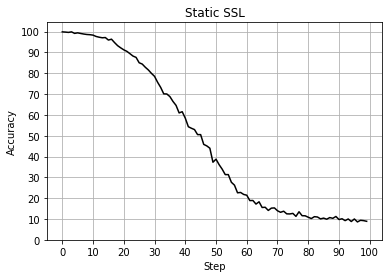

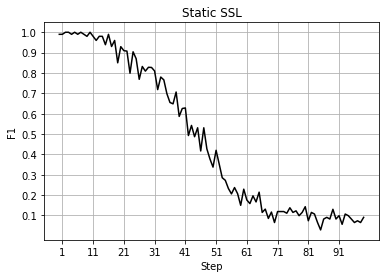

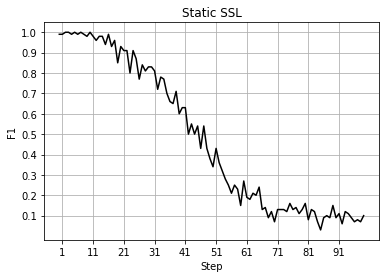




METHOD: Sliding lp as classifier
Execution time:  2.8847840350000027
Average MCC:  0.39220877684406674
Average error: 31.432500000000005
Average macro-F1: 0.5971445414437264
Average micro-F1: 0.6772
Average Accuracy:  68.5675
Standard Deviation:  19.70705489792932
Variance:  388.36801275000005


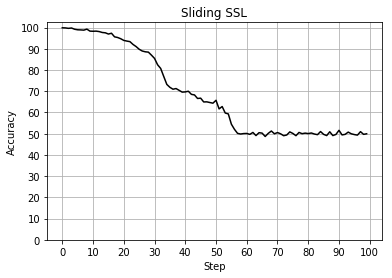

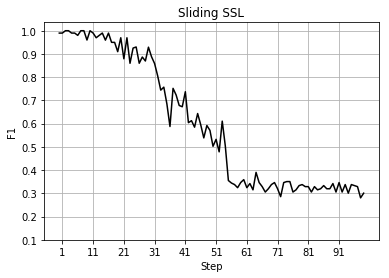

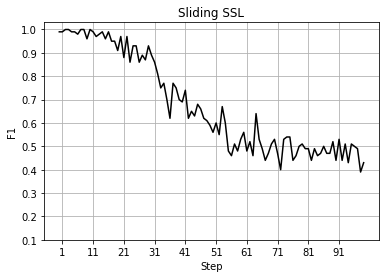




METHOD: Incremental lp as classifier
Execution time:  125.58201358000001
Average MCC:  -0.013123912914606626
Average error: 51.1642
Average macro-F1: 0.48826239225177703
Average micro-F1: 0.49249999999999994
Average Accuracy:  48.8358
Standard Deviation:  36.90785797577529
Variance:  1362.18998036


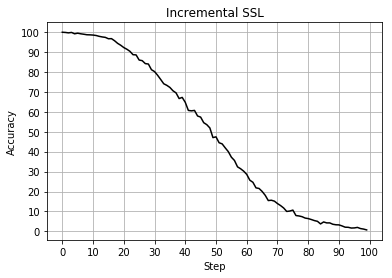

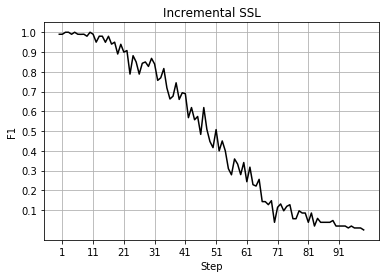

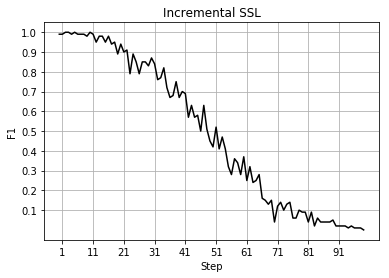




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  26.009447327999993
Average MCC:  0.40278249131296795
Average error: 31.0068
Average macro-F1: 0.6096888486778379
Average micro-F1: 0.6828
Average Accuracy:  68.9932
Standard Deviation:  19.132007259041064
Variance:  366.03370176


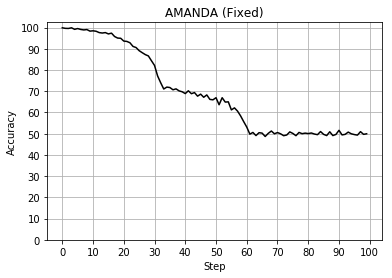

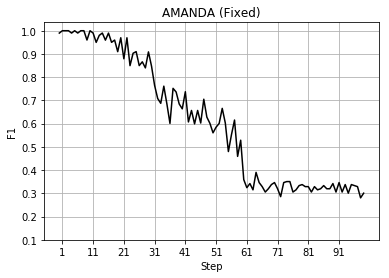

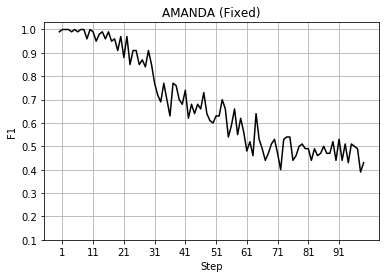




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.33 | Std keeping percentage=0.19
Execution time:  26.279685726000025
Average MCC:  0.4249864367241096
Average error: 29.272900000000007
Average macro-F1: 0.7055912933187328
Average micro-F1: 0.7105
Average Accuracy:  70.7271
Standard Deviation:  19.907418883170166
Variance:  396.3053265900001


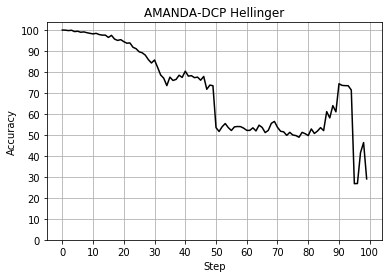

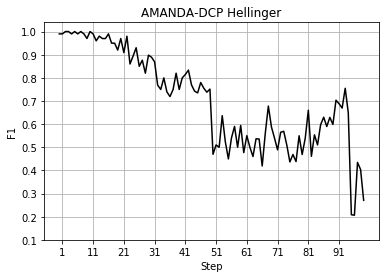

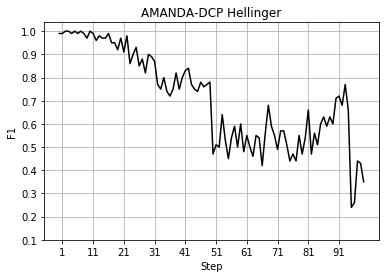




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.22 | Std keeping percentage=0.05
Execution time:  21.511637207999996
Average MCC:  0.8114308381301568
Average error: 10.491
Average macro-F1: 0.8976644313094506
Average micro-F1: 0.9007000000000001
Average Accuracy:  89.509
Standard Deviation:  8.209381889034034
Variance:  67.39395100000002


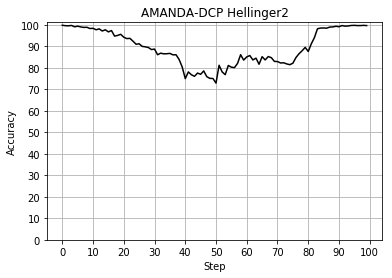

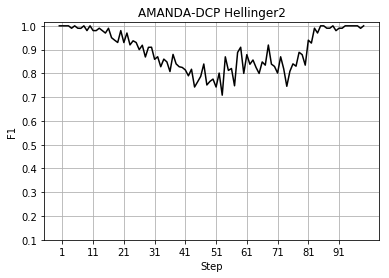

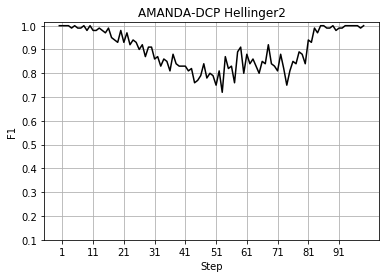




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.21 | Std keeping percentage=0.10
Execution time:  20.533591012999977
Average MCC:  0.7700989793502352
Average error: 12.591000000000008
Average macro-F1: 0.8763971102096848
Average micro-F1: 0.88
Average Accuracy:  87.40899999999999
Standard Deviation:  10.647656314889206
Variance:  113.37258499999999


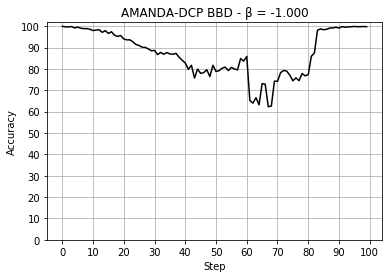

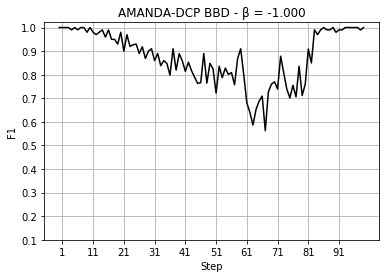

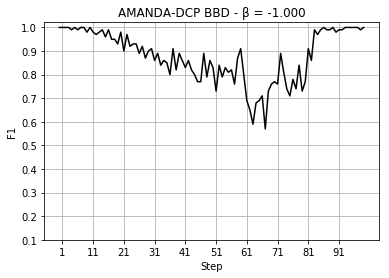




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = 2.000 | Mean keeping percentage=0.15 | Std keeping percentage=0.04
Execution time:  21.215341292000005
Average MCC:  0.46941169370343416
Average error: 27.43650000000001
Average macro-F1: 0.7276073385973028
Average micro-F1: 0.7334999999999998
Average Accuracy:  72.56349999999999
Standard Deviation:  20.254914780121887
Variance:  410.26157275


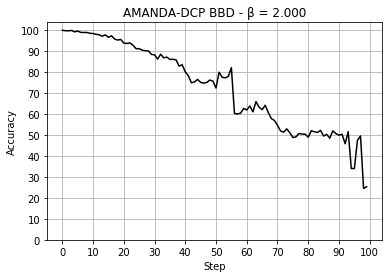

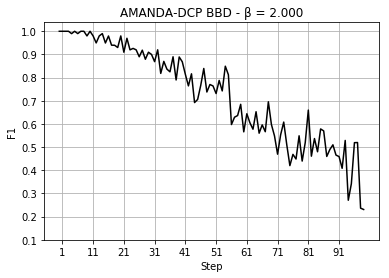

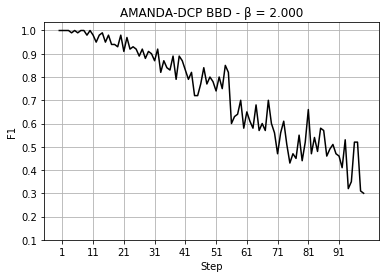




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = 3.000 | Mean keeping percentage=0.16 | Std keeping percentage=0.04
Execution time:  24.873230618000036
Average MCC:  0.4390691877461088
Average error: 28.867099999999994
Average macro-F1: 0.7127986787318425
Average micro-F1: 0.7193999999999999
Average Accuracy:  71.1329
Standard Deviation:  23.118625577442963
Variance:  534.47084859


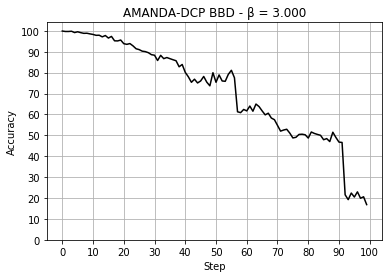

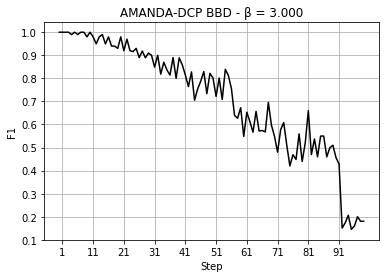

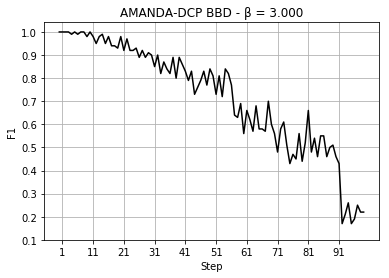




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = 10.000 | Mean keeping percentage=0.18 | Std keeping percentage=0.06
Execution time:  20.894646206000004
Average MCC:  0.44719569617149474
Average error: 28.519900000000007
Average macro-F1: 0.7157900681305833
Average micro-F1: 0.7216999999999999
Average Accuracy:  71.4801
Standard Deviation:  19.94951124689525
Variance:  397.98299899


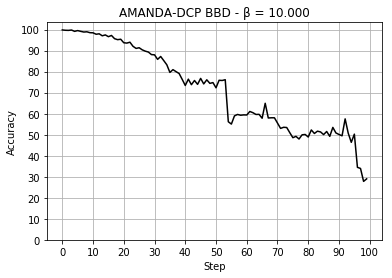

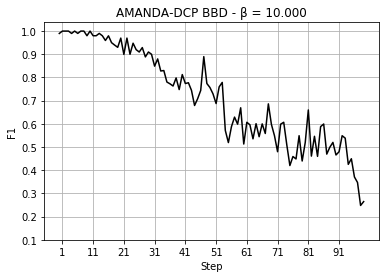

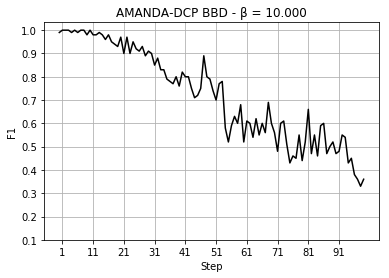

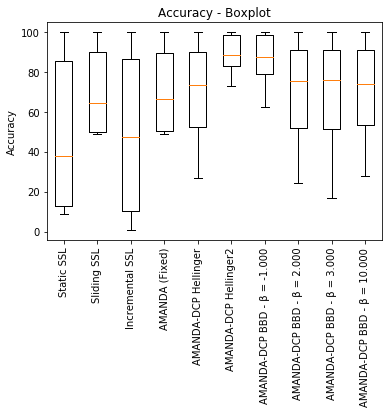

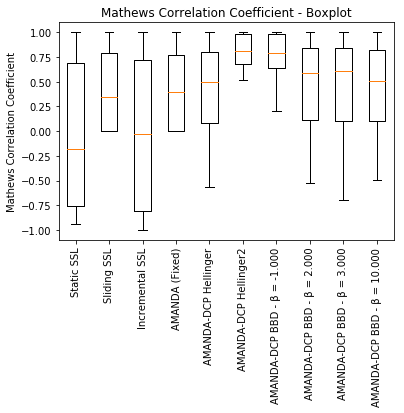

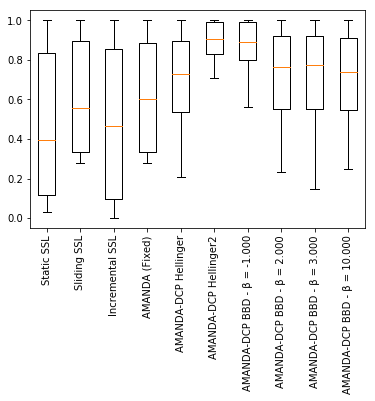

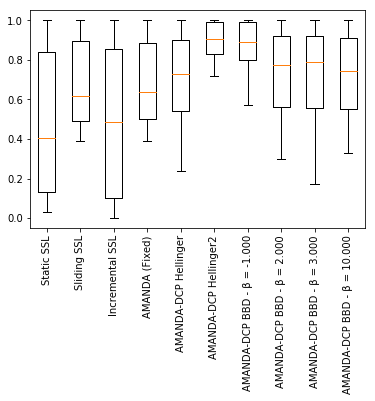

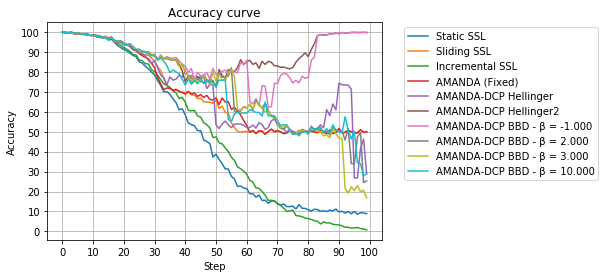

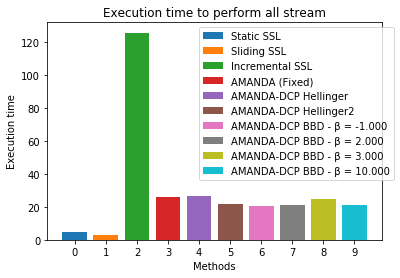

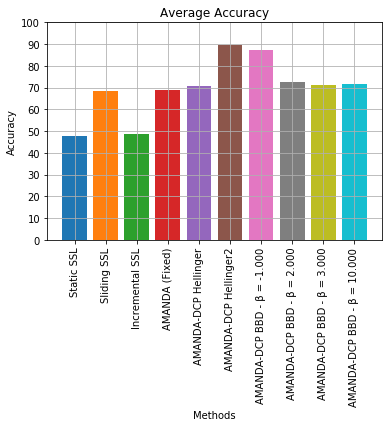

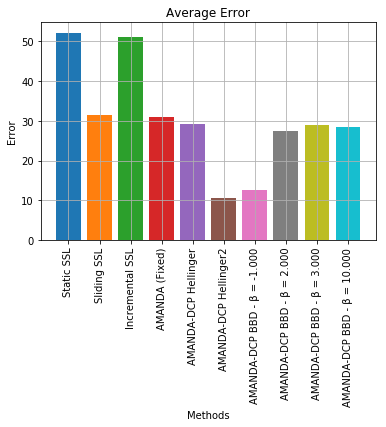

Pos 8 - Error reduction (Sliding SSL):43.292867696384405
Pos 9 - Error reduction (Incremental SSL):2.0574153680255227
Pos 7 - Error reduction (AMANDA (Fixed)):44.1824986990949
Pos 6 - Error reduction (AMANDA-DCP Hellinger):47.80601571953111
Pos 1 - Error reduction (AMANDA-DCP Hellinger2):87.05656899603564
Pos 2 - Error reduction (AMANDA-DCP BBD - β = -1.000):82.66797349288314
Pos 3 - Error reduction (AMANDA-DCP BBD - β = 2.000):51.643737996668825
Pos 5 - Error reduction (AMANDA-DCP BBD - β = 3.000):48.65405955533079
Pos 4 - Error reduction (AMANDA-DCP BBD - β = 10.000):49.37964067851864


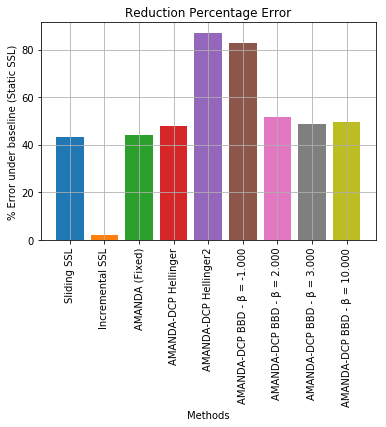

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadMG_2C_2D(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 8, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 8, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 8, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 8, 0.55, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 8, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 11, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    betas = [-1, 2, 3, 10]
    bestK = [11, 11, 11, 7]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])

    # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 11, None, "kde", sslClassifier, 'HDDDM')
    
    
    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 11)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'MG_2C_2D', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()